<h3>Libraries</h3>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize

# CAPM 


$$
    r_M \sim \mathcal{N}(\alpha + \beta r_A, \varepsilon) \ \forall A
$$

$$
    {\bf w} = (\Phi^T\Phi)^{-1} \Phi{\bf t}
$$

## Optimización de los pesos

In [5]:
dataset = pd.read_excel("./utils/PreciosPortf.xlsx", index_col=0)
rend = dataset.pct_change().dropna()

columnas2 = []

for c in dataset.columns:
    columnas2.append(c.replace(" MF Equity",""))

dataset.columns = columnas2
rend.columns = columnas2

rend_ports = rend.mean() * 252
print(rend_ports)

dataset.head()

ASURB       0.123539
GFNORTEO    0.078811
PE&OLES*    0.111053
WALMEX*     0.082426
IENOVA*     0.078997
dtype: float64


,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98
2016-01-05,233.03,91.72,176.45,42.66,71.48
2016-01-06,231.97,91.63,172.68,42.38,70.94
2016-01-07,230.71,89.54,172.94,39.99,72.31


In [6]:
# Rendimientos diarios
rend.head()

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148


In [7]:
# Varianza-covarianza
rend.cov()

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
ASURB,0.000224,0.000086,0.000061,0.000036,0.000044
GFNORTEO,0.000086,0.000341,0.000094,0.000082,0.000082
PE&OLES*,0.000061,0.000094,0.000548,0.000041,0.000045
WALMEX*,0.000036,0.000082,0.000041,0.000215,0.000043
IENOVA*,0.000044,0.000082,0.000045,0.000043,0.000226


In [8]:
varcov = rend.cov()

weights = np.random.random(5)
weights /= sum(weights)
print("weights => {}".format(weights))
print("sum(weights) => {}\n".format(sum(weights)))

weights => [0.20980915 0.22133726 0.03061494 0.32931447 0.20892417]
sum(weights) => 1.0



In [9]:
(rend.mean() * weights).sum() * 252

0.09041182974475742

In [10]:
E_p = (rend.mean() @ weights) * 252
S_p = np.sqrt(weights.T @ (rend.cov() * 252) @ weights)
print("E_p => {}".format(E_p))
print("S_p => {}".format(S_p))

E_p => 0.09041182974475744
S_p => 0.16337233284985275


In [11]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights) * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

print("port_rend(weights, rend) => {}".format(port_rend(weights, rend)))
print("port_vol(weights, rend => {}".format(port_vol(weights, rend)))

port_rend(weights, rend) => 0.09041182974475744
port_vol(weights, rend => 0.16337233284985275


In [12]:
weights_sim = np.random.random((5000, 5))
weights_sim = weights_sim / weights_sim.sum(axis=1, keepdims=True)

rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim = np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

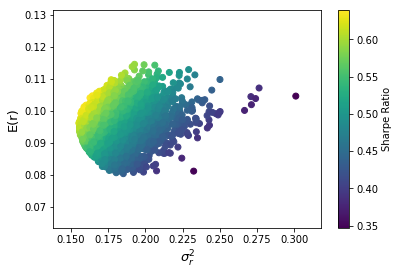

In [13]:
# Ratio para cada escenario simulado
sharpe_ratio = rend_sim / vol_sim

plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13);

### Creando la frontera eficiente

$$
\begin{aligned}
    \min \ &{\bf w}^T\Sigma {\bf w} \\
    s.t.\ & {\bf w}^T {\bf 1} = 1 \\
\end{aligned}
$$

### Optimización sujeta a un rendimiento esperado


$$
\begin{aligned}
    \min \ &{\bf w}^T\Sigma {\bf w} \\
    s.t.\ & {\bf w}^T {\bf 1} = 1 \\
    &{\bf w}^T R_p = E
\end{aligned}
$$

In [14]:
N, M = rend.shape
w0  = np.random.randn(M)
rend_maxs = np.linspace(rend_ports.min(), rend_ports.max())

def sum_weights(weights):
    return weights.sum() - 1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

def neg_weights(weights):
    return min(weights)


In [15]:
pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_maxs: #para cada uno de los rendimiento que voy a evaluar y graficar en el eje x
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)


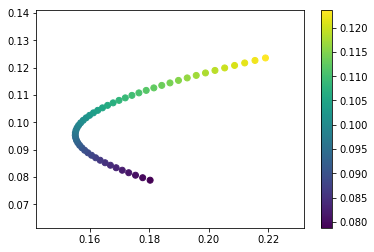

In [16]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w, rend))
    v_opt.append(port_vol(w, rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt, r_opt, c=r_opt)
plt.colorbar()

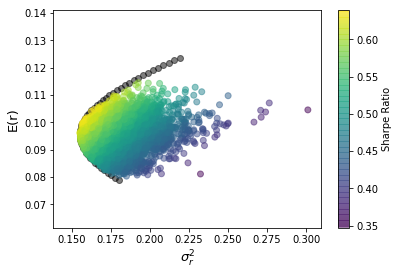

In [17]:
plt.scatter(v_opt,r_opt, c= "black",alpha=.5)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

### Portafolio Tangencial

$$
    \mathbb{E}[R_C] = R_f + \frac{\mathbb{E}[R_p] - R_f}{\sigma_P}\sigma_C
$$

$$
\frac{\mathbb{E}[R_p] - R_f}{\sigma_P}
$$

In [18]:
rf = 0.06

def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf) / port_vol(weights, rend)

constraints = [
    {"type": "eq", "fun": sum_weights}
]

f_sharpe = minimize(min_func_sharpe, w0, constraints=constraints)
print("f_sharpe =>\n\n{}\n".format(f_sharpe))


f_sharpe =>

     fun: -0.2918522976684256
     jac: array([-0.30294063, -0.30292967, -0.30290907, -0.30296817, -0.30297143])
 message: 'Optimization terminated successfully.'
    nfev: 332
     nit: 43
    njev: 43
  status: 0
 success: True
       x: array([ 0.73107055, -0.14059211,  0.17631457,  0.16469195,  0.06851504])



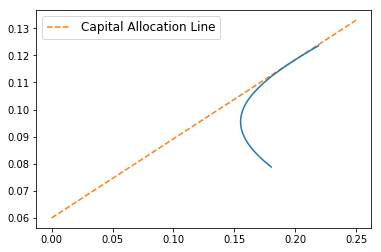

In [19]:
w_sharpe = f_sharpe.x

e_sharpe = port_rend(w_sharpe, rend)
vol_sharpe = port_vol(w_sharpe, rend)

sigma_c =  np.linspace(0, 0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c, sharpe, linestyle="--", c="tab:orange", label="Capital Allocation Line")
plt.plot(v_opt, r_opt)
plt.legend(fontsize=12)

In [20]:
def port_rend(weights):
    return np.sum(rend.mean()*weights)*252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rend.cov()*252,weights)))

In [21]:
S = 10000000
weights = w_sharpe

anuales =[]
for i in range(5):
    anuales.append((np.sqrt(varcov.iloc[i,i]))*np.sqrt(252))
print("anuales =>\n{}\n".format(anuales))

posiciones =[]
for i in range(5):
    posiciones.append(S*weights[i])
print("posiciones =>\n{}\n".format(posiciones))

anuales =>
[0.23747683132280767, 0.2932968797198881, 0.3715522629370927, 0.2328565568585489, 0.23842444015669614]

posiciones =>
[7310705.452154347, -1405921.1121053083, 1763145.732883602, 1646919.5133168132, 685150.4137505465]



In [27]:
var_95_d = []
for i in range(5):
    var_95_d.append(1.65*posiciones[i]*(anuales[i]*(1/np.sqrt(252))))
    
var_99_d = []
for i in range(5):
    var_99_d.append(2.33*posiciones[i]*(anuales[i]*(1/np.sqrt(252))))
    
var_95_a = []
for i in range(5):
    var_95_a.append(1.65*posiciones[i]*(anuales[i]))
    
var_99_a = []
for i in range(5):
    var_99_a.append(2.33*posiciones[i]*(anuales[i]))

print("=========================================================================\n")
print("VaR diario - 95% => {}".format(S * 1.65 * port_vol(weights) * 1/np.sqrt(252)))
print("VaR diario - 99% => {}".format(S * 2.33 * port_vol(weights) * 1/np.sqrt(252)))
print("VaR anual - 95%  => {}".format(S * 1.65 * port_vol(weights)))
print("VaR anual - 99%  => {}\n".format(S * 2.33 * port_vol(weights)))
print("=========================================================================\n")
print("Diversificacion - VaR diario - 95% => {}".format(
    sum(var_95_d)-(S * 1.65 * port_vol(weights) * 1/np.sqrt(252))))
print("Diversificacion - VaR diario - 99% => {}".format(
    sum(var_99_d)-(S * 2.33 * port_vol(weights) * 1/np.sqrt(252))))
print("Diversificacion - VaR anual - 95%  => {}".format(
    sum(var_95_a)-(S * 1.65 * port_vol(weights))))
print("Diversificacion - VaR anual - 99%  => {}\n".format(
    sum(var_99_a)-(S * 2.33 * port_vol(weights))))
print("=========================================================================")


VaR diario - 95% => 205860.78431069895
VaR diario - 99% => 290700.3802690476
VaR anual - 95%  => 3267938.6399209
VaR anual - 99%  => 4614725.473342846


Diversificacion - VaR diario - 95% => 56663.579323021026
Diversificacion - VaR diario - 99% => 80015.8423167509
Diversificacion - VaR anual - 95%  => 899506.4357009721
Diversificacion - VaR anual - 99%  => 1270212.1182928886

